In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from scipy import special as sp
import scipy.integrate as integrate
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from scipy.constants import fine_structure, speed_of_light, electron_mass, elementary_charge, hbar, epsilon_0
from scipy.stats import moment
rng = np.random.default_rng()

In [2]:
#variáveis e constantes
electron_radius = elementary_charge**2/(4*pi*epsilon_0*electron_mass*speed_of_light**2)
num_pon = 10000                                                   #número de pontos
mean_ene = 1800                                                    #energia média inicial
std_div = 90                                                       #desvio padrão
mag_field = np.array([2.5*10**3, 2.5*10**4, 2.5*10**5, 2.5*10**6]) #[T] intensidade do campo magnético
chi_0 = 1                                                          #valor de chi máximo
tau_e = hbar/(speed_of_light**2*electron_mass)                     #[s] time it takes for light to travel across the electron radius electron_radius/speed_of_light#
n_bins = 75                                                        #número de bins do histograma
t_end = np.array([20, 20, 5, 3])                                   #tempos finais
t_steps = 1000                                                       #numero de steps

In [3]:
#definir as funções auxiliares

def cnst_prop_2(mag):
    return mag / (4.5 * 10 ** (9))


# definir a função h

def integration_func_h(x, X):
    return (2 * x ** 2 * sp.kv(5 / 3, x)) / (2 + 3 * x * X) ** 2 + (
            sp.kv(2 / 3, x) * 4 * x * (3 * x * X) ** 2) / (
                   2 + 3 * x * X) ** 4


def integration_h(X):
    return (9 * 3 ** 0.5 / (8 * pi)) * \
           integrate.quad(lambda x: integration_func_h(x, X), 0, np.Inf)[0]


# definir a função g

def integration_func_g(x, X):
    return (2 * x ** 3 * X ** 3 * sp.kv(5 / 3, x)) / (
                2 + 3 * x * X) ** 3 + (
                   sp.kv(2 / 3, x) * 54 * x ** 4 * X ** 5) / (
                   2 + 3 * x * X) ** 5

def integration_g(X):
    return (9 * 3 ** 0.5 / (4 * pi)) * \
           integrate.quad(lambda x: integration_func_g(x, X), 0, np.Inf)[0]

chi_int_1 = np.linspace(0.0005, chi_0*1.1, int(num_pon/10))

S = np.array([integration_h(x) for x in chi_int_1])

func_h = CubicSpline(chi_int_1, S)

R = np.array([integration_g(x) for x in chi_int_1])

func_g = CubicSpline(chi_int_1, R)

In [4]:
def CLL(mean_ene, std_div, num_pon, t_steps, mag_field, t_end):
    gamma_final = []

    media_energia = []

    var_energia = []

    skew_energia = []

    for j in tqdm(range(len(t_end))):
        # valores de gamma
        gamma_glob = mean_ene + std_div * rng.standard_normal(num_pon)

        gamma_glob_1 = np.array(gamma_glob)

        media_glob = np.zeros(t_steps)

        var_glob = np.zeros(t_steps)

        skew_glob = np.zeros(t_steps)

        time_step = t_end[j] / t_steps

        omega_c = elementary_charge * mag_field[j] / (
                electron_mass * mean_ene)  # synchrotron frequency

        for i in range(t_steps):
            d_gamma = func_h(gamma_glob_1 * cnst_prop_2(mag_field[j])) * ((2 / 3) * fine_structure / tau_e / omega_c * (gamma_glob_1 * cnst_prop_2(mag_field[j])) ** 2) * time_step

            gamma_glob_1 -= d_gamma

            # proibir gammas menores que 1 (impossibilidade física)
            for l in range(len(gamma_glob)):
                if (gamma_glob_1[l] <= 1):
                    gamma_glob_1[l] = 1

            if i == int(t_steps / 2) - 1:  # gamma em t = tend/2
                gamma_glob_2 = np.array(gamma_glob_1)  # gamma em t = tend/2

            media_glob[i] = (np.sum(gamma_glob_1) / num_pon) / mean_ene
            var_glob[i] = np.var(gamma_glob_1) / mean_ene ** 2
            skew_glob[i] = moment(gamma_glob_1, moment=3)/mean_ene**3

        gamma_final += [[gamma_glob, gamma_glob_2, gamma_glob_1]]
        media_energia += [media_glob]
        var_energia += [var_glob]
        skew_energia += [skew_glob]

    return [gamma_final, media_energia, var_energia, skew_energia]

In [5]:
def Fokker_Planck(mean_ene, std_div, num_pon, t_steps, mag_field, t_end):
    # aplicar o fokker-planck pusher

    gamma_final = []

    media_energia = []

    var_energia = []

    skew_energia = []

    for j in tqdm(range(len(t_end))):
        # valores de gamma
        gamma_glob = mean_ene + std_div * np.random.randn(num_pon)

        gamma_glob_1 = np.array(gamma_glob)

        media_glob = np.zeros(t_steps)

        var_glob = np.zeros(t_steps)

        skew_glob = np.zeros(t_steps)

        time_step = t_end[j] / t_steps

        omega_c = elementary_charge * mag_field[j] / (
                electron_mass * mean_ene)  # synchrotron frequency

        for i in range(t_steps):

            dW = np.sqrt(time_step) * np.random.randn(num_pon)

            poss_neg = func_g(gamma_glob_1 * cnst_prop_2(mag_field[j])) * ((2 / 3) * fine_structure / tau_e / omega_c) * gamma_glob_1

            d_gamma_1 = np.sqrt(poss_neg) * dW

            d_gamma_2 = func_h(gamma_glob_1 * cnst_prop_2(mag_field[j])) * (
                        (2 / 3) * fine_structure / tau_e / omega_c * (
                            gamma_glob_1 * cnst_prop_2(
                        mag_field[j])) ** 2) * time_step

            d_gamma = d_gamma_1 - d_gamma_2

            gamma_glob_1 += d_gamma

            #tentar minimizar as instâncias de NaN
            for k in range(num_pon - 1):
                if np.isnan(gamma_glob_1[k]) == True:
                    gamma_glob_1[k] = gamma_glob_1[k + 1]

            # proibir gammas menores que 1 (impossibilidade física)
            for l in range(len(gamma_glob)):
                if (gamma_glob_1[l] <= 1):
                    gamma_glob_1[l] = 1

            if i == int(t_steps / 2) - 1:  # gamma em t = tend/2
                gamma_glob_2 = np.array(gamma_glob_1)  # gamma em t = tend/2


            media_glob[i] = (np.sum(gamma_glob_1)/num_pon)/mean_ene
            var_glob[i] = np.var(gamma_glob_1)/mean_ene**2
            skew_glob[i] = moment(gamma_glob_1, moment=3)/mean_ene**3

        gamma_final += [[gamma_glob, gamma_glob_2, gamma_glob_1]]
        media_energia += [media_glob]
        var_energia += [var_glob]
        skew_energia += [skew_glob]

    return [gamma_final, media_energia, var_energia, skew_energia]

In [6]:
Beam_evolution = Fokker_Planck(mean_ene, std_div, num_pon, t_steps, mag_field, t_end)

Beam_evolution_cll = CLL(mean_ene, std_div, num_pon, t_steps, mag_field, t_end)

<ipython-input-5-1d2fa36ef7b4>:12: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  for j in tqdm(range(len(t_end))):
100%|██████████| 4/4 [00:57<00:00, 14.32s/it]


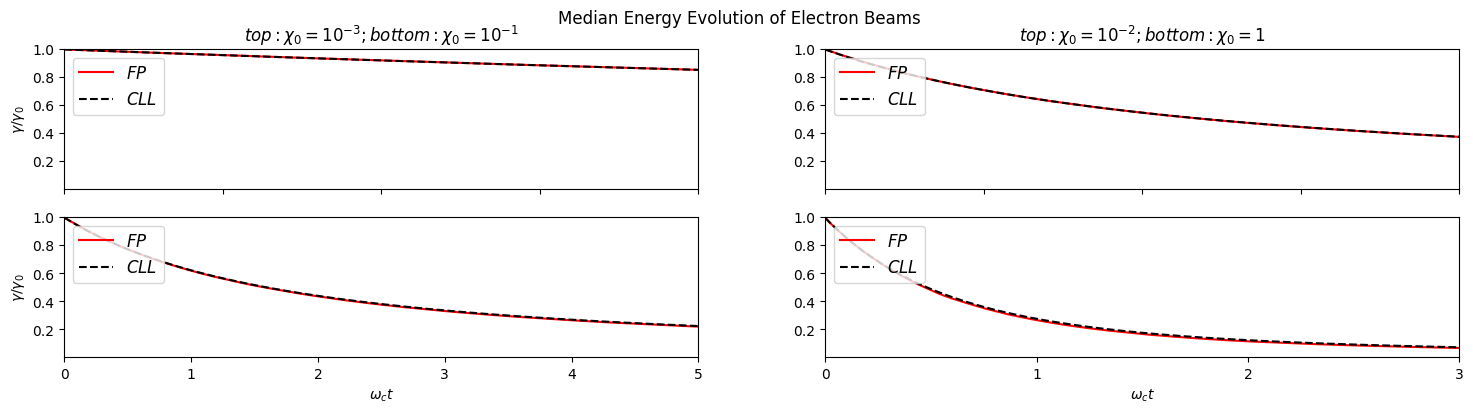

In [7]:
fig_1, axis_1 = plt.subplots(2, 2, figsize=(18,4))

fig_1.suptitle('Median Energy Evolution of Electron Beams')

axis_1[0, 0].set_xlim([0, 20])
axis_1[0, 0].set_ylim([0, 1])

axis_1[0, 0].set_title('${top:}\chi_{0}=10^{-3}{;bottom:}\chi_{0}=10^{-1}$')

axis_1[0, 0].set_xticks([0, 5, 10, 15, 20])
axis_1[0, 0].set_yticks([0.2, 0.4, 0.6, 0.8, 1])

axis_1[0, 0].set_ylabel('${\gamma}/{\gamma_0}$')

axis_1[0, 1].set_xlim([0, 20])
axis_1[0, 1].set_ylim([0, 1])

axis_1[0, 1].set_xticks([0, 5, 10, 15, 20])
axis_1[0, 1].set_yticks([0.2, 0.4, 0.6, 0.8, 1])

axis_1[0, 1].set_title('${top:}\chi_{0}=10^{-2}{;bottom:}\chi_{0}=1$')

axis_1[1, 0].set_xlim([0, 5])
axis_1[1, 0].set_ylim([0, 1])

axis_1[1, 0].set_xticks([0, 1, 2, 3, 4, 5])
axis_1[1, 0].set_yticks([0.2, 0.4, 0.6, 0.8, 1])

axis_1[1, 0].set_ylabel('${\gamma}/{\gamma_0}$')
axis_1[1, 0].set_xlabel('${\omega}_ct$')

axis_1[1, 1].set_xlim([0, 3])
axis_1[1, 1].set_ylim([0, 1])

axis_1[1, 1].set_xticks([0, 1, 2, 3])
axis_1[1, 1].set_yticks([0.2, 0.4, 0.6, 0.8, 1])

axis_1[1, 1].set_xlabel('${\omega}_ct$')

axis_1[0,0].tick_params(
    axis='x',
    which='both',
    bottom=True,
    top=False,
    labelbottom=False)
axis_1[0,1].tick_params(
    axis='x',
    which='both',
    bottom=True,
    top=False,
    labelbottom=False)

for i in range(len(Beam_evolution[1])):
    x_axis = np.linspace(0, t_end[i], t_steps)

    if i == 0:
        axis_1[0, 0].plot(x_axis, Beam_evolution[1][i], color='red',linestyle='solid', label=r'$FP$')
        axis_1[0, 0].plot(x_axis, Beam_evolution_cll[1][i], color='black',linestyle='dashed', label=r'$CLL$')

    if i == 1:
        axis_1[0, 1].plot(x_axis, Beam_evolution[1][i], color='red',linestyle='solid', label=r'$FP$')
        axis_1[0, 1].plot(x_axis, Beam_evolution_cll[1][i], color='black',linestyle='dashed', label=r'$CLL$')

    if i == 2:
        axis_1[1, 0].plot(x_axis, Beam_evolution[1][i], color='red',linestyle='solid', label=r'$FP$')
        axis_1[1, 0].plot(x_axis, Beam_evolution_cll[1][i], color='black',linestyle='dashed', label=r'$CLL$')

    if i == 3:
        axis_1[1, 1].plot(x_axis, Beam_evolution[1][i], color='red',linestyle='solid', label=r'$FP$')
        axis_1[1, 1].plot(x_axis, Beam_evolution_cll[1][i], color='black',linestyle='dashed', label=r'$CLL$')

axis_1[0, 0].legend(loc=2, prop={'size': 12})
axis_1[0, 1].legend(loc=2, prop={'size': 12})
axis_1[1, 0].legend(loc=2, prop={'size': 12})
axis_1[1, 1].legend(loc=2, prop={'size': 12})

plt.show()

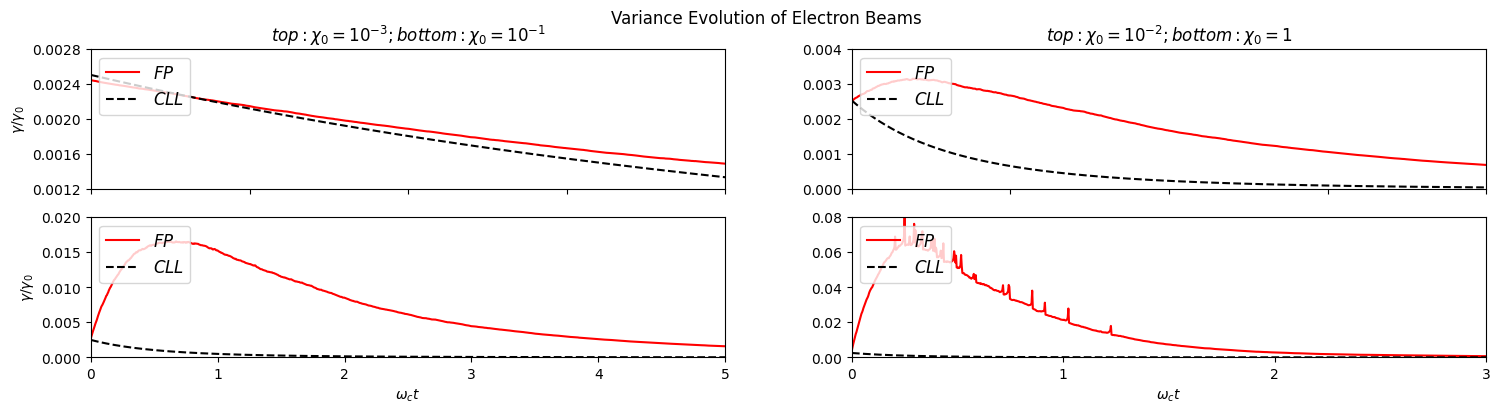

In [8]:
fig_2, axis_2 = plt.subplots(2, 2, figsize=(18,4))

fig_2.suptitle('Variance Evolution of Electron Beams')

axis_2[0, 0].set_xlim([0, 20])
axis_2[0, 0].set_ylim([0.0012, 0.0028])

axis_2[0, 0].set_title('${top:}\chi_{0}=10^{-3}{;bottom:}\chi_{0}=10^{-1}$')

axis_2[0, 0].set_xticks([0, 5, 10, 15, 20])
axis_2[0, 0].set_yticks([0.0012, 0.0016, 0.0020, 0.0024, 0.0028])


axis_2[0, 0].set_ylabel('${\gamma}/{\gamma_0}$')

axis_2[0, 1].set_xlim([0, 20])
axis_2[0, 1].set_ylim([0, 0.004])

axis_2[0, 1].set_xticks([0, 5, 10, 15, 20])
axis_2[0, 1].set_yticks([0, 0.001, 0.002, 0.003, 0.004])

axis_2[0, 1].set_title('${top:}\chi_{0}=10^{-2}{;bottom:}\chi_{0}=1$')

axis_2[1, 0].set_xlim([0, 5])
axis_2[1, 0].set_ylim([0, 0.02])

axis_2[1, 0].set_xticks([0, 1, 2, 3, 4, 5])
axis_2[1, 0].set_yticks([0, 0.005, 0.01, 0.015, 0.02])

axis_2[1, 0].set_ylabel('${\gamma}/{\gamma_0}$')
axis_2[1, 0].set_xlabel('${\omega}_ct$')

axis_2[1, 1].set_xlim([0, 3])
axis_2[1, 1].set_ylim([0, 0.08])

axis_2[1, 1].set_xticks([0, 1, 2, 3])
axis_2[1, 1].set_yticks([0, 0.02, 0.04 , 0.06, 0.08])

axis_2[1, 1].set_xlabel('${\omega}_ct$')

axis_2[0,0].tick_params(
    axis='x',
    which='both',
    bottom=True,
    top=False,
    labelbottom=False)
axis_2[0,1].tick_params(
    axis='x',
    which='both',
    bottom=True,
    top=False,
    labelbottom=False)

for i in range(len(Beam_evolution[1])):
    x_axis = np.linspace(0, t_end[i], t_steps)

    if i == 0:
        axis_2[0, 0].plot(x_axis, Beam_evolution[2][i], color='red',linestyle='solid', label=r'$FP$')
        axis_2[0, 0].plot(x_axis, Beam_evolution_cll[2][i], color='black',linestyle='dashed', label=r'$CLL$')

    if i == 1:
        axis_2[0, 1].plot(x_axis, Beam_evolution[2][i], color='red',linestyle='solid', label=r'$FP$')
        axis_2[0, 1].plot(x_axis, Beam_evolution_cll[2][i], color='black',linestyle='dashed', label=r'$CLL$')

    if i == 2:
        axis_2[1, 0].plot(x_axis, Beam_evolution[2][i], color='red',linestyle='solid', label=r'$FP$')
        axis_2[1, 0].plot(x_axis, Beam_evolution_cll[2][i], color='black',linestyle='dashed', label=r'$CLL$')

    if i == 3:
        axis_2[1, 1].plot(x_axis, Beam_evolution[2][i], color='red',linestyle='solid', label=r'$FP$')
        axis_2[1, 1].plot(x_axis, Beam_evolution_cll[2][i], color='black',linestyle='dashed', label=r'$CLL$')

axis_2[0, 0].legend(loc=2, prop={'size': 12})
axis_2[0, 1].legend(loc=2, prop={'size': 12})
axis_2[1, 0].legend(loc=2, prop={'size': 12})
axis_2[1, 1].legend(loc=2, prop={'size': 12})

plt.show()

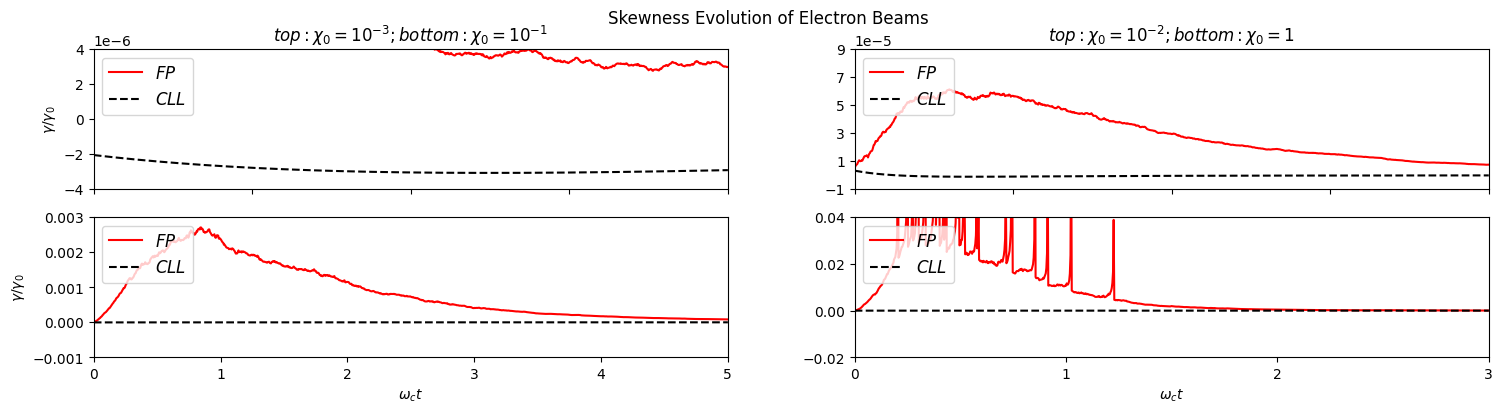

In [9]:
fig_3, axis_3 = plt.subplots(2, 2, figsize=(18,4))

fig_3.suptitle('Skewness Evolution of Electron Beams')

axis_3[0, 0].set_xlim([0, 20])
axis_3[0, 0].set_ylim([-4*10**(-6), 4*10**(-6)])

axis_3[0, 0].set_title('${top:}\chi_{0}=10^{-3}{;bottom:}\chi_{0}=10^{-1}$')

axis_3[0, 0].set_xticks([0, 5, 10, 15, 20])
axis_3[0, 0].set_yticks([-4*10**(-6), -2*10**(-6), 0*10**(-6), 2*10**(-6), 4*10**(-6)])#axis_3[0, 0].set_yticks([0, 2*10**(-6), 4*10**(-6), 6*10**(-6), 8*10**(-6)])


axis_3[0, 0].set_ylabel('${\gamma}/{\gamma_0}$')

axis_3[0, 1].set_xlim([0, 20])
axis_3[0, 1].set_ylim([-1*10**(-5), 9*10**(-5)])

axis_3[0, 1].set_xticks([0, 5, 10, 15, 20])
axis_3[0, 1].set_yticks([-1*10**(-5), 1*10**(-5), 3*10**(-5), 5*10**(-5), 7*10**(-5), 9*10**(-5)])

axis_3[0, 1].set_title('${top:}\chi_{0}=10^{-2}{;bottom:}\chi_{0}=1$')

axis_3[1, 0].set_xlim([0, 5])
axis_3[1, 0].set_ylim([-1*10**(-3), 3*10**(-3)])

axis_3[1, 0].set_xticks([0, 1, 2, 3, 4, 5])
axis_3[1, 0].set_yticks([-1*10**(-3), 0*10**(-3), 1*10**(-3), 2*10**(-3), 3*10**(-3)])

axis_3[1, 0].set_ylabel('${\gamma}/{\gamma_0}$')
axis_3[1, 0].set_xlabel('${\omega}_ct$')

axis_3[1, 1].set_xlim([0, 3])
axis_3[1, 1].set_ylim([-2*10**(-2), 4*10**(-2)])

axis_3[1, 1].set_xticks([0, 1, 2, 3])
axis_3[1, 1].set_yticks([-2*10**(-2), 0*10**(-3), 2*10**(-2), 4*10**(-2)])

axis_3[1, 1].set_xlabel('${\omega}_ct$')

axis_3[0,0].tick_params(
    axis='x',
    which='both',
    bottom=True,
    top=False,
    labelbottom=False)
axis_3[0,1].tick_params(
    axis='x',
    which='both',
    bottom=True,
    top=False,
    labelbottom=False)

for i in range(len(Beam_evolution[1])):
    x_axis = np.linspace(0, t_end[i], t_steps)

    if i == 0:
        axis_3[0, 0].plot(x_axis, Beam_evolution[3][i], color='red', linestyle='solid', label=r'$FP$')
        axis_3[0, 0].plot(x_axis, Beam_evolution_cll[3][i], color='black',linestyle='dashed', label=r'$CLL$')

    if i == 1:
        axis_3[0, 1].plot(x_axis, Beam_evolution[3][i], color='red',linestyle='solid', label=r'$FP$')
        axis_3[0, 1].plot(x_axis, Beam_evolution_cll[3][i], color='black',linestyle='dashed', label=r'$CLL$')

    if i == 2:
        axis_3[1, 0].plot(x_axis, Beam_evolution[3][i], color='red',linestyle='solid', label=r'$FP$')
        axis_3[1, 0].plot(x_axis, Beam_evolution_cll[3][i], color='black',linestyle='dashed', label=r'$CLL$')

    if i == 3:
        axis_3[1, 1].plot(x_axis, Beam_evolution[3][i], color='red',linestyle='solid', label=r'$FP$')
        axis_3[1, 1].plot(x_axis, Beam_evolution_cll[3][i], color='black',linestyle='dashed', label=r'$CLL$')

axis_3[0, 0].legend(loc=2, prop={'size': 12})
axis_3[0, 1].legend(loc=2, prop={'size': 12})
axis_3[1, 0].legend(loc=2, prop={'size': 12})
axis_3[1, 1].legend(loc=2, prop={'size': 12})

plt.show()

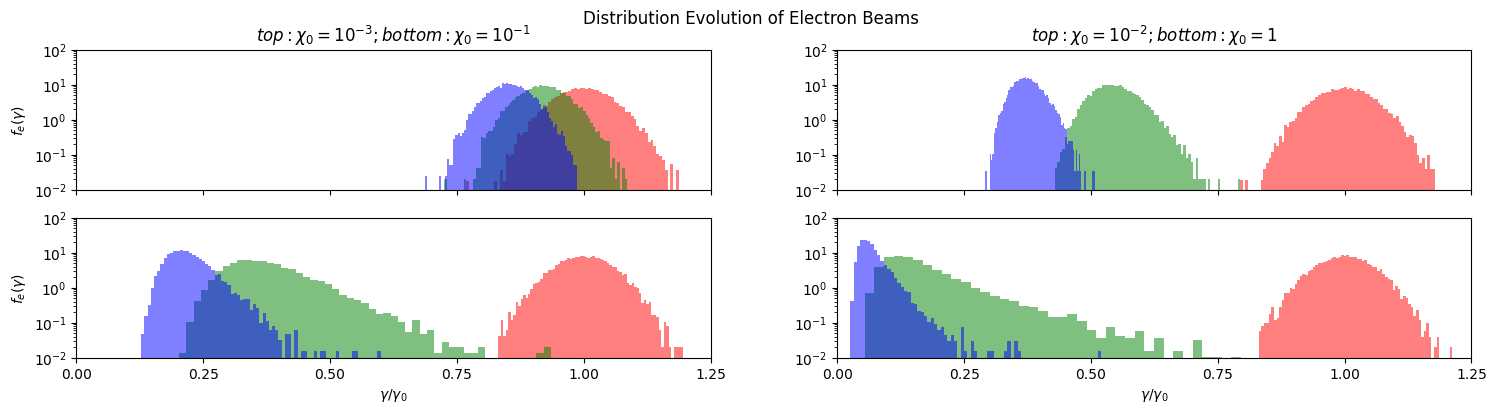

In [10]:
fig, axis = plt.subplots(2, 2, figsize=(18,4))

fig.suptitle('Distribution Evolution of Electron Beams')

axis[0, 0].set_yscale('log')

axis[0, 0].set_xlim([0, 1.25])
axis[0, 0].set_ylim([0.01, 100])

axis[0, 0].set_title('${top:}\chi_{0}=10^{-3}{;bottom:}\chi_{0}=10^{-1}$')

axis[0, 0].set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])

axis[0, 0].set_ylabel('$f_e(\gamma)$')

axis[0, 1].set_yscale('log')

axis[0, 1].set_xlim([0, 1.25])
axis[0, 1].set_ylim([0.01, 100])

axis[0, 1].set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])

axis[0, 1].set_title('${top:}\chi_{0}=10^{-2}{;bottom:}\chi_{0}=1$')

axis[1, 0].set_yscale('log')

axis[1, 0].set_xlim([0, 1.25])
axis[1, 0].set_ylim([0.01, 100])

axis[1, 0].set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])

axis[1, 0].set_xlabel('${\gamma}/{\gamma_0}$')
axis[1, 0].set_ylabel('$f_e(\gamma)$')

axis[1, 1].set_yscale('log')

axis[1, 1].set_xlim([0, 1.25])
axis[1, 1].set_ylim([0.01, 100])

axis[1, 1].set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])

axis[1, 1].set_xlabel('${\gamma}/{\gamma_0}$')

axis[0,0].tick_params(
    axis='x',
    which='both',
    bottom=True,
    top=False,
    labelbottom=False)
axis[0,1].tick_params(
    axis='x',
    which='both',
    bottom=True,
    top=False,
    labelbottom=False)


for i in range(len(Beam_evolution[0])):
        # histograma em t=0

        if i == 0 or i == 1:

            axis[0, i].hist(Beam_evolution[0][i][0] / mean_ene, n_bins, density=True,
                            color='red', alpha=0.5,
                            histtype='bar')

            # histograma em t = tend/2
            axis[0, i].hist(Beam_evolution[0][i][1] / mean_ene, n_bins, density=True,
                            color='green', alpha=0.5,
                            histtype='bar')

            # histograma em t = tend
            axis[0, i].hist(Beam_evolution[0][i][2] / mean_ene, n_bins, density=True,
                            color='blue', alpha=0.5,
                            histtype='bar')

        else:
            axis[1, i-2].hist(Beam_evolution[0][i][0] / mean_ene, n_bins,
                            density=True,
                            color='red', alpha=0.5,
                            histtype='bar')

            # histograma em t = tend/2
            axis[1, i-2].hist(Beam_evolution[0][i][1] / mean_ene, n_bins,
                            density=True,
                            color='green', alpha=0.5,
                            histtype='bar')

            # histograma em t = tend
            axis[1, i-2].hist(Beam_evolution[0][i][2] / mean_ene, n_bins,
                            density=True,
                            color='blue', alpha=0.5,
                            histtype='bar')
            
plt.show()